# Evaluating Models
## 1. Introduction
In this notebook, we do a very basic evaluation of each model against a manually generated dataset.
We will compare:
- BinaryNet
- XNOR-NET
- ABCNet

## 2. Generating Data
### 2.1 Function
We will choose a quadratic function:
$$
  F(x)=ax^2+bx+c
$$
### 2.2 Parameters
We will set:
- $a=2$
- $b=3$
- $c=2$

### 2.3 Data
1. We will generate $n=20000$ samples $X_1,\dots,X_n$ from the uniform distribution $\mathcal{U}(-4,4)$
2. We will generate $n=20000$ samples $\epsilon_1,\dots,\epsilon_n$ from the normal distribution $\mathcal{N}(0,\sigma),$ with $\sigma=0.1$
3. We will calculate $y_1,\dots,y_n$ as:
    $$
    y_i=aX_i^2+bX_i+c+\epsilon_i
    $$

In [1]:
import tensorflow as tf
import larq as lq
import numpy as np
from binaryflow import quantizers,layers
from sklearn.model_selection import train_test_split
from binaryflow.layers.XnorNet import *
from binaryflow.layers.ABCNet import *
from binaryflow.layers.BinaryNet import *
from binaryflow.block.BiRealNet import *
from codecarbon import EmissionsTracker


a=2
b=3
c=2
n=20000
std=0.1
np.random.seed(21)
tf.random.set_seed(27)
X=np.random.uniform(-4,4,[n,1])
err=np.random.normal(0,std,[n,1])
y=a*X**2+b*X+c+err
def F(x):
    return a*x**2+b*x+c

2022-08-23 16:26:00.432329: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-23 16:26:00.683211: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-23 16:26:00.683658: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-23 16:26:00.685283: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## 3. Creating Models

In [2]:
binarynet_args = dict(
    kernel_quantizer="ste_sign",
    input_quantizer="ste_sign",
    kernel_constraint="weight_clip",
    #kernel_params={"mu_initializer":tf.keras.initializers.RandomNormal(0,0.05)},
    use_bias=False
)

xnornet_args = dict(
    kernel_quantizer="ste_sign",
    input_quantizer="ste_sign",
    kernel_constraint="weight_clip",
    #kernel_params={"mu_initializer":tf.keras.initializers.RandomNormal(0,0.05)},
    use_bias=False,
    alpha_trainable=True
)

abcnet_args = dict(
    kernel_estimators=3,
    kernel_quantizers=quantizers.ShiftedSteSign,
    input_quantizers=quantizers.ShiftedSteSign,
    kernel_constraint="weight_clip",
    kernel_params={"mu_initializer":tf.keras.initializers.RandomNormal(0,0.05)},
    use_bias=False
)

mlp_args={}

X_train,X_test,y_train,y_test=train_test_split(X,y)


models={}
noisy_models={}
model_names=["BinaryNet","XNOR-NET","ABCNet","MLP"]
model_layers={"BinaryNet":lq.layers.QuantDense,"XNOR-NET":ScaledQuantDense,"ABCNet":ABCDense,"MLP":tf.keras.layers.Dense}

for name,kwargs in zip(model_names,[binarynet_args,xnornet_args,abcnet_args,mlp_args]):
    Dense=model_layers[name]
    layers=[tf.keras.layers.Dense(24),
            tf.keras.layers.BatchNormalization(momentum=0.999,scale=False),
            Dense(24,activation="relu", **kwargs),
            tf.keras.layers.BatchNormalization(momentum=0.999,scale=False),
            Dense(24,activation="relu", **kwargs),
            tf.keras.layers.BatchNormalization(momentum=0.999,scale=False),
            Dense(1, **kwargs)]
    models[name]=tf.keras.models.Sequential(layers)
    noisy_models[name]=tf.keras.models.Sequential([
        tf.keras.layers.GaussianNoise(stddev=.5),
        *layers
    ])


## 4. Fitting Models

In [3]:
emissions={}
for model_family in [models]:
    for name in model_family:
        tracker=EmissionsTracker()
        tracker.start()
        model=model_family[name]
        model.compile(
            tf.keras.optimizers.Adam(lr=0.01, decay=0.0001),
            loss="mean_squared_error"
        )
        model.fit(
            X_train,
            y_train,
            batch_size=128,
            epochs=29,
            validation_data=(X_test, y_test),
            shuffle=True
        )
        emissions[name]=tracker.stop()


[codecarbon INFO @ 16:27:52] [setup] RAM Tracking...
[codecarbon INFO @ 16:27:52] [setup] GPU Tracking...
[codecarbon INFO @ 16:27:52] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 16:27:52] [setup] CPU Tracking...
[codecarbon ERROR @ 16:27:52] Unable to read Intel RAPL files for CPU power, we will use a constant for your CPU power. Please view https://github.com/mlco2/codecarbon/issues/244 for workarounds : [Errno 13] Permission denied: '/sys/class/powercap/intel-rapl/intel-rapl:0/energy_uj'
[codecarbon INFO @ 16:27:52] Tracking Intel CPU via RAPL interface
[codecarbon ERROR @ 16:27:52] Unable to read Intel RAPL files for CPU power, we will use a constant for your CPU power. Please view https://github.com/mlco2/codecarbon/issues/244 for workarounds : [Errno 13] Permission denied: '/sys/class/powercap/intel-rapl/intel-rapl:0/energy_uj'
[codecarbon INFO @ 16:27:52] >>> Tracker's metadata:
[codecarbon INFO @ 16:27:52]   Platform system: Linux-5.18.11-200.fc36.x86_64-x86_64-with-glibc

Epoch 1/29


/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


118/118 [==============================] - 4s 8ms/step - loss: 118.2091 - val_loss: 90.1460
Epoch 2/29
118/118 [==============================] - 1s 6ms/step - loss: 66.2616 - val_loss: 137.7582
Epoch 3/29
118/118 [==============================] - 1s 6ms/step - loss: 51.5887 - val_loss: 116.6982
Epoch 4/29
118/118 [==============================] - 1s 7ms/step - loss: 49.1794 - val_loss: 127.3195
Epoch 5/29
118/118 [==============================] - 1s 6ms/step - loss: 43.6950 - val_loss: 171.1839
Epoch 6/29
118/118 [==============================] - 1s 6ms/step - loss: 41.9250 - val_loss: 166.9535
Epoch 7/29
118/118 [==============================] - 1s 6ms/step - loss: 41.0786 - val_loss: 144.4790
Epoch 8/29
118/118 [==============================] - 1s 6ms/step - loss: 38.7183 - val_loss: 98.8839
Epoch 9/29
118/118 [==============================] - 1s 5ms/step - loss: 38.3887 - val_loss: 94.3750
Epoch 10/29
118/118 [==============================] - 1s 7ms/step - loss: 39.2039 - v

[codecarbon INFO @ 16:28:11] Energy consumed for RAM : 0.000049 kWh. RAM Power : 11.672304153442383 W
[codecarbon INFO @ 16:28:11] Energy consumed for all GPUs : 0.000107 kWh. All GPUs Power : 25.6 W
[codecarbon INFO @ 16:28:11] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 16:28:11] 0.000155 kWh of electricity used since the begining.


118/118 [==============================] - 1s 7ms/step - loss: 35.7694 - val_loss: 107.3460
Epoch 17/29
118/118 [==============================] - 1s 6ms/step - loss: 36.3447 - val_loss: 77.7426
Epoch 18/29
118/118 [==============================] - 1s 7ms/step - loss: 36.2432 - val_loss: 76.2798
Epoch 19/29
118/118 [==============================] - 1s 7ms/step - loss: 35.4616 - val_loss: 87.2205
Epoch 20/29
118/118 [==============================] - 1s 7ms/step - loss: 36.5866 - val_loss: 90.1080
Epoch 21/29
118/118 [==============================] - 1s 7ms/step - loss: 36.5463 - val_loss: 89.2906
Epoch 22/29
118/118 [==============================] - 1s 7ms/step - loss: 36.4116 - val_loss: 67.4764
Epoch 23/29
118/118 [==============================] - 1s 7ms/step - loss: 36.3832 - val_loss: 81.6686
Epoch 24/29
118/118 [==============================] - 1s 7ms/step - loss: 35.7830 - val_loss: 83.5284
Epoch 25/29
118/118 [==============================] - 1s 7ms/step - loss: 36.3512 -

[codecarbon INFO @ 16:28:22] Energy consumed for RAM : 0.000084 kWh. RAM Power : 11.672304153442383 W
[codecarbon INFO @ 16:28:22] Energy consumed for all GPUs : 0.000188 kWh. All GPUs Power : 27.003 W
[codecarbon INFO @ 16:28:22] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 16:28:22] 0.000271 kWh of electricity used since the begining.
[codecarbon INFO @ 16:28:22] [setup] RAM Tracking...
[codecarbon INFO @ 16:28:22] [setup] GPU Tracking...
[codecarbon INFO @ 16:28:22] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 16:28:22] [setup] CPU Tracking...
[codecarbon ERROR @ 16:28:22] Unable to read Intel RAPL files for CPU power, we will use a constant for your CPU power. Please view https://github.com/mlco2/codecarbon/issues/244 for workarounds : [Errno 13] Permission denied: '/sys/class/powercap/intel-rapl/intel-rapl:0/energy_uj'
[codecarbon INFO @ 16:28:22] Tracking Intel CPU via RAPL interface
[codecarbon ERROR @ 16:28:22] Unable to read Intel

Epoch 1/29


/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


118/118 [==============================] - 2s 10ms/step - loss: 104.7517 - val_loss: 182.5300
Epoch 2/29
118/118 [==============================] - 1s 8ms/step - loss: 19.3805 - val_loss: 183.6751
Epoch 3/29
118/118 [==============================] - 1s 8ms/step - loss: 12.9124 - val_loss: 178.3081
Epoch 4/29
118/118 [==============================] - 1s 9ms/step - loss: 12.5509 - val_loss: 114.5628
Epoch 5/29
118/118 [==============================] - 1s 9ms/step - loss: 9.2707 - val_loss: 67.7262
Epoch 6/29
118/118 [==============================] - 1s 10ms/step - loss: 9.4314 - val_loss: 130.6987
Epoch 7/29
118/118 [==============================] - 1s 10ms/step - loss: 11.5223 - val_loss: 100.4483
Epoch 8/29
118/118 [==============================] - 1s 9ms/step - loss: 10.1044 - val_loss: 52.2406
Epoch 9/29
118/118 [==============================] - 1s 8ms/step - loss: 9.8843 - val_loss: 100.9679
Epoch 10/29
118/118 [==============================] - 1s 9ms/step - loss: 9.5886 - v

[codecarbon INFO @ 16:28:41] Energy consumed for RAM : 0.000049 kWh. RAM Power : 11.672304153442383 W
[codecarbon INFO @ 16:28:41] Energy consumed for all GPUs : 0.000110 kWh. All GPUs Power : 26.418 W
[codecarbon INFO @ 16:28:41] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 16:28:41] 0.000159 kWh of electricity used since the begining.


118/118 [==============================] - 1s 8ms/step - loss: 9.3465 - val_loss: 41.0805
Epoch 15/29
118/118 [==============================] - 1s 8ms/step - loss: 10.3726 - val_loss: 44.9285
Epoch 16/29
118/118 [==============================] - 1s 8ms/step - loss: 9.2495 - val_loss: 44.8724
Epoch 17/29
118/118 [==============================] - 1s 9ms/step - loss: 10.6051 - val_loss: 14.5550
Epoch 18/29
118/118 [==============================] - 1s 8ms/step - loss: 11.5072 - val_loss: 8.9659
Epoch 19/29
118/118 [==============================] - 1s 8ms/step - loss: 9.4252 - val_loss: 34.9379
Epoch 20/29
118/118 [==============================] - 1s 8ms/step - loss: 12.0749 - val_loss: 36.2110
Epoch 21/29
118/118 [==============================] - 1s 9ms/step - loss: 11.0698 - val_loss: 16.1121
Epoch 22/29
118/118 [==============================] - 1s 9ms/step - loss: 10.1206 - val_loss: 42.4494
Epoch 23/29
118/118 [==============================] - 1s 9ms/step - loss: 9.8446 - val_l

[codecarbon INFO @ 16:28:56] Energy consumed for RAM : 0.000097 kWh. RAM Power : 11.672304153442383 W
[codecarbon INFO @ 16:28:56] Energy consumed for all GPUs : 0.000216 kWh. All GPUs Power : 25.486 W
[codecarbon INFO @ 16:28:56] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 16:28:56] 0.000313 kWh of electricity used since the begining.


118/118 [==============================] - 1s 9ms/step - loss: 10.3846 - val_loss: 20.6814


[codecarbon INFO @ 16:28:57] Energy consumed for RAM : 0.000100 kWh. RAM Power : 11.672304153442383 W
[codecarbon INFO @ 16:28:57] Energy consumed for all GPUs : 0.000223 kWh. All GPUs Power : 25.559 W
[codecarbon INFO @ 16:28:57] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 16:28:57] 0.000323 kWh of electricity used since the begining.
[codecarbon INFO @ 16:28:57] [setup] RAM Tracking...
[codecarbon INFO @ 16:28:57] [setup] GPU Tracking...
[codecarbon INFO @ 16:28:57] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 16:28:57] [setup] CPU Tracking...
[codecarbon ERROR @ 16:28:57] Unable to read Intel RAPL files for CPU power, we will use a constant for your CPU power. Please view https://github.com/mlco2/codecarbon/issues/244 for workarounds : [Errno 13] Permission denied: '/sys/class/powercap/intel-rapl/intel-rapl:0/energy_uj'
[codecarbon INFO @ 16:28:57] Tracking Intel CPU via RAPL interface
[codecarbon ERROR @ 16:28:57] Unable to read Intel

Epoch 1/29


/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


118/118 [==============================] - 4s 16ms/step - loss: 49.9114 - val_loss: 228.9061
Epoch 2/29
118/118 [==============================] - 2s 13ms/step - loss: 6.4384 - val_loss: 140.0354
Epoch 3/29
118/118 [==============================] - 1s 12ms/step - loss: 5.3098 - val_loss: 258.8068
Epoch 4/29
118/118 [==============================] - 1s 12ms/step - loss: 4.7903 - val_loss: 98.9893
Epoch 5/29
118/118 [==============================] - 1s 13ms/step - loss: 5.4966 - val_loss: 31.4005
Epoch 6/29
118/118 [==============================] - 2s 13ms/step - loss: 5.0948 - val_loss: 17.7622
Epoch 7/29
118/118 [==============================] - 2s 13ms/step - loss: 4.9885 - val_loss: 32.7883
Epoch 8/29
118/118 [==============================] - 2s 13ms/step - loss: 4.6175 - val_loss: 22.4942
Epoch 9/29
 10/118 [=>............................] - ETA: 1s - loss: 3.3914

[codecarbon INFO @ 16:29:15] Energy consumed for RAM : 0.000049 kWh. RAM Power : 11.672304153442383 W
[codecarbon INFO @ 16:29:15] Energy consumed for all GPUs : 0.000108 kWh. All GPUs Power : 25.959 W
[codecarbon INFO @ 16:29:15] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 16:29:15] 0.000157 kWh of electricity used since the begining.


118/118 [==============================] - 1s 12ms/step - loss: 3.9670 - val_loss: 44.3003
Epoch 10/29
118/118 [==============================] - 1s 12ms/step - loss: 3.2449 - val_loss: 73.0504
Epoch 11/29
118/118 [==============================] - 1s 13ms/step - loss: 3.4996 - val_loss: 47.5601
Epoch 12/29
118/118 [==============================] - 1s 12ms/step - loss: 3.4266 - val_loss: 125.1572
Epoch 13/29
118/118 [==============================] - 1s 12ms/step - loss: 3.9640 - val_loss: 51.1302
Epoch 14/29
118/118 [==============================] - 1s 12ms/step - loss: 3.8904 - val_loss: 44.1151
Epoch 15/29
118/118 [==============================] - 1s 12ms/step - loss: 4.0846 - val_loss: 41.6795
Epoch 16/29
118/118 [==============================] - 1s 12ms/step - loss: 3.8396 - val_loss: 37.0728
Epoch 17/29
118/118 [==============================] - 1s 12ms/step - loss: 3.6673 - val_loss: 31.4120
Epoch 18/29
118/118 [==============================] - 1s 12ms/step - loss: 4.1301 -

[codecarbon INFO @ 16:29:30] Energy consumed for RAM : 0.000097 kWh. RAM Power : 11.672304153442383 W
[codecarbon INFO @ 16:29:30] Energy consumed for all GPUs : 0.000216 kWh. All GPUs Power : 25.915 W
[codecarbon INFO @ 16:29:30] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 16:29:30] 0.000313 kWh of electricity used since the begining.


118/118 [==============================] - 1s 13ms/step - loss: 3.2633 - val_loss: 42.1790
Epoch 20/29
118/118 [==============================] - 1s 12ms/step - loss: 4.0809 - val_loss: 75.5646
Epoch 21/29
118/118 [==============================] - 1s 12ms/step - loss: 3.6212 - val_loss: 103.2553
Epoch 22/29
118/118 [==============================] - 1s 12ms/step - loss: 3.2314 - val_loss: 46.4705
Epoch 23/29
118/118 [==============================] - 1s 12ms/step - loss: 3.7387 - val_loss: 13.2688
Epoch 24/29
118/118 [==============================] - 1s 12ms/step - loss: 4.1049 - val_loss: 21.8270
Epoch 25/29
118/118 [==============================] - 1s 13ms/step - loss: 3.5944 - val_loss: 127.0240
Epoch 26/29
118/118 [==============================] - 2s 13ms/step - loss: 3.7196 - val_loss: 25.5214
Epoch 27/29
118/118 [==============================] - 2s 13ms/step - loss: 3.5412 - val_loss: 6.2579
Epoch 28/29
118/118 [==============================] - 1s 13ms/step - loss: 3.5929 -

[codecarbon INFO @ 16:29:45] Energy consumed for RAM : 0.000146 kWh. RAM Power : 11.672304153442383 W
[codecarbon INFO @ 16:29:45] Energy consumed for all GPUs : 0.000325 kWh. All GPUs Power : 26.109000000000005 W
[codecarbon INFO @ 16:29:45] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 16:29:45] 0.000471 kWh of electricity used since the begining.


118/118 [==============================] - 2s 13ms/step - loss: 3.5362 - val_loss: 27.3600


[codecarbon INFO @ 16:29:46] Energy consumed for RAM : 0.000148 kWh. RAM Power : 11.672304153442383 W
[codecarbon INFO @ 16:29:46] Energy consumed for all GPUs : 0.000330 kWh. All GPUs Power : 27.245 W
[codecarbon INFO @ 16:29:46] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 16:29:46] 0.000478 kWh of electricity used since the begining.
[codecarbon INFO @ 16:29:46] [setup] RAM Tracking...
[codecarbon INFO @ 16:29:46] [setup] GPU Tracking...
[codecarbon INFO @ 16:29:46] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 16:29:46] [setup] CPU Tracking...
[codecarbon ERROR @ 16:29:46] Unable to read Intel RAPL files for CPU power, we will use a constant for your CPU power. Please view https://github.com/mlco2/codecarbon/issues/244 for workarounds : [Errno 13] Permission denied: '/sys/class/powercap/intel-rapl/intel-rapl:0/energy_uj'
[codecarbon INFO @ 16:29:46] Tracking Intel CPU via RAPL interface
[codecarbon ERROR @ 16:29:46] Unable to read Intel

Epoch 1/29


/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


118/118 [==============================] - 1s 6ms/step - loss: 65.4997 - val_loss: 40.3861
Epoch 2/29
118/118 [==============================] - 1s 6ms/step - loss: 3.1030 - val_loss: 28.2998
Epoch 3/29
118/118 [==============================] - 1s 6ms/step - loss: 2.7966 - val_loss: 23.8838
Epoch 4/29
118/118 [==============================] - 1s 6ms/step - loss: 3.1058 - val_loss: 14.7796
Epoch 5/29
118/118 [==============================] - 1s 6ms/step - loss: 2.9408 - val_loss: 17.4910
Epoch 6/29
118/118 [==============================] - 1s 7ms/step - loss: 3.4751 - val_loss: 20.6078
Epoch 7/29
118/118 [==============================] - 1s 6ms/step - loss: 3.2560 - val_loss: 11.3237
Epoch 8/29
118/118 [==============================] - 1s 6ms/step - loss: 3.1340 - val_loss: 10.9275
Epoch 9/29
118/118 [==============================] - 1s 6ms/step - loss: 3.3019 - val_loss: 9.0331
Epoch 10/29
118/118 [==============================] - 1s 6ms/step - loss: 2.7738 - val_loss: 6.6355
E

[codecarbon INFO @ 16:30:05] Energy consumed for RAM : 0.000049 kWh. RAM Power : 11.672304153442383 W
[codecarbon INFO @ 16:30:05] Energy consumed for all GPUs : 0.000111 kWh. All GPUs Power : 26.576000000000004 W
[codecarbon INFO @ 16:30:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 16:30:05] 0.000159 kWh of electricity used since the begining.


118/118 [==============================] - 1s 6ms/step - loss: 2.8733 - val_loss: 0.5670
Epoch 22/29
118/118 [==============================] - 1s 6ms/step - loss: 2.7016 - val_loss: 1.3334
Epoch 23/29
118/118 [==============================] - 1s 5ms/step - loss: 2.8422 - val_loss: 1.8580
Epoch 24/29
118/118 [==============================] - 1s 5ms/step - loss: 2.8402 - val_loss: 7.5974
Epoch 25/29
118/118 [==============================] - 1s 6ms/step - loss: 2.6633 - val_loss: 0.1985
Epoch 26/29
118/118 [==============================] - 1s 6ms/step - loss: 3.0586 - val_loss: 2.5093
Epoch 27/29
118/118 [==============================] - 1s 6ms/step - loss: 3.3014 - val_loss: 6.2798
Epoch 28/29
118/118 [==============================] - 1s 6ms/step - loss: 3.6448 - val_loss: 6.1521
Epoch 29/29
118/118 [==============================] - 1s 7ms/step - loss: 3.2084 - val_loss: 9.7298


[codecarbon INFO @ 16:30:11] Energy consumed for RAM : 0.000067 kWh. RAM Power : 11.672304153442383 W
[codecarbon INFO @ 16:30:11] Energy consumed for all GPUs : 0.000153 kWh. All GPUs Power : 25.972 W
[codecarbon INFO @ 16:30:11] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 16:30:11] 0.000220 kWh of electricity used since the begining.


## 5. Plotting Boundaries

32/32 [==============================] - 0s 1ms/step


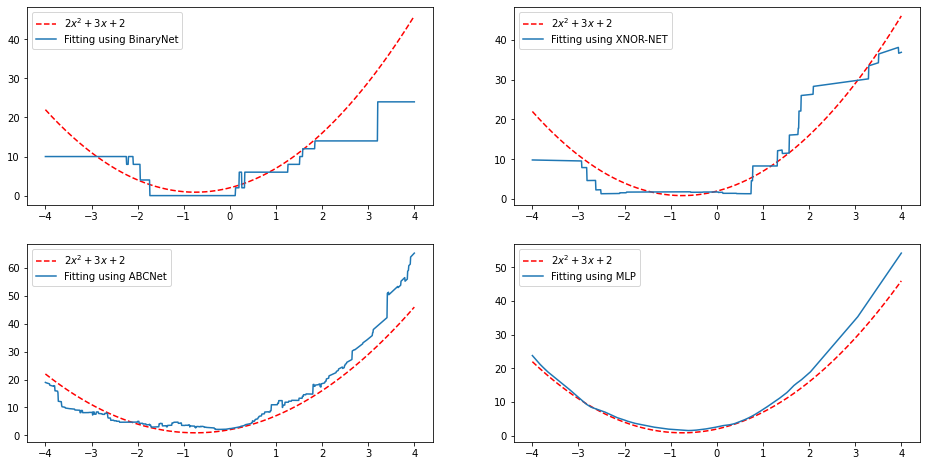

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tck
fig,axs=plt.subplots(2,2,figsize=(16,8))
def plot_models(X,models,axs=None):
    names=[]
    for name in models:
        names.append(name)
    for i,axz in enumerate(axs):
        for j ,ax in enumerate(axz):
            sns.lineplot(x=U,y=a*U**2+b*U+c,ax=ax,label=f"${a}x^2+{b}x+{c}$",color="red",linestyle='--')
            name=names[2*i+j]
            sns.lineplot(x=U,y=models[name].predict(U.reshape((-1,1))).reshape((-1,)),ax=ax,label=f"Fitting using {name}")
            ax.tick_params(which="both", bottom=True)

m=1000
U=np.linspace(-4,4,m)
plot_models(U,models,axs)
#axs.set_title("Comparison between models predictions")
fig.savefig("local/model-performances-quadratic2.svg")

## 6. Distribution of parameters

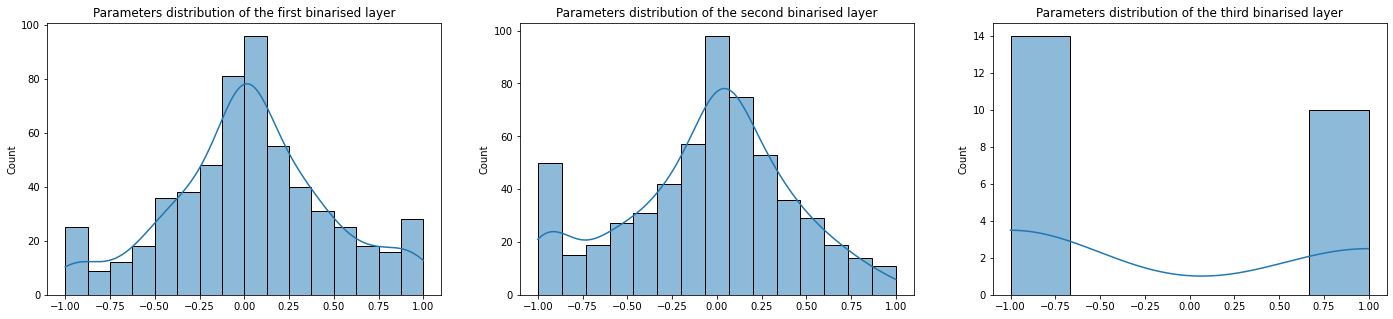

In [22]:
W=[models["BinaryNet"].layers[2*i+2].kernel for i in range(3)]
def count_name(n):
    if n==1:
        return "first"
    if n==2:
        return "second"
    if n==3:
        return "third"


fig,axs=plt.subplots(1,3,figsize=(24,5))
for i,(w,ax) in enumerate(zip(W,axs)):
    sns.histplot(w.numpy().flatten(),ax=ax,kde=True)
    ax.set_title(f"Parameters distribution of the {count_name(i+1)} binarised layer")
fig.savefig("parameters-distribution-xnor-net.svg")

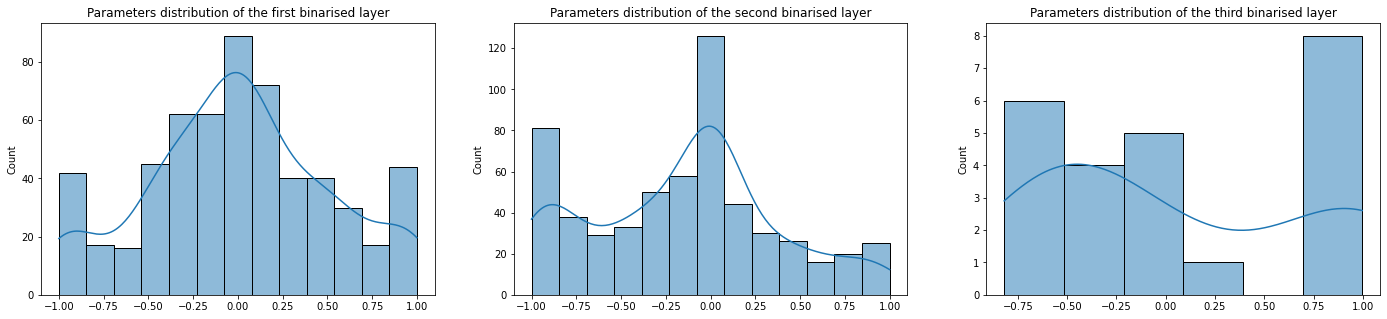

In [14]:
W=[models["XNOR-NET"].layers[2*i+2].kernel for i in range(3)]

fig,axs=plt.subplots(1,3,figsize=(24,5))
for i,(w,ax) in enumerate(zip(W,axs)):
    sns.histplot(w.numpy().flatten(),ax=ax,kde=True)
    ax.set_title(f"Parameters distribution of the {count_name(i+1)} binarised layer")
fig.savefig("parameters-distribution-xnor-net.svg")

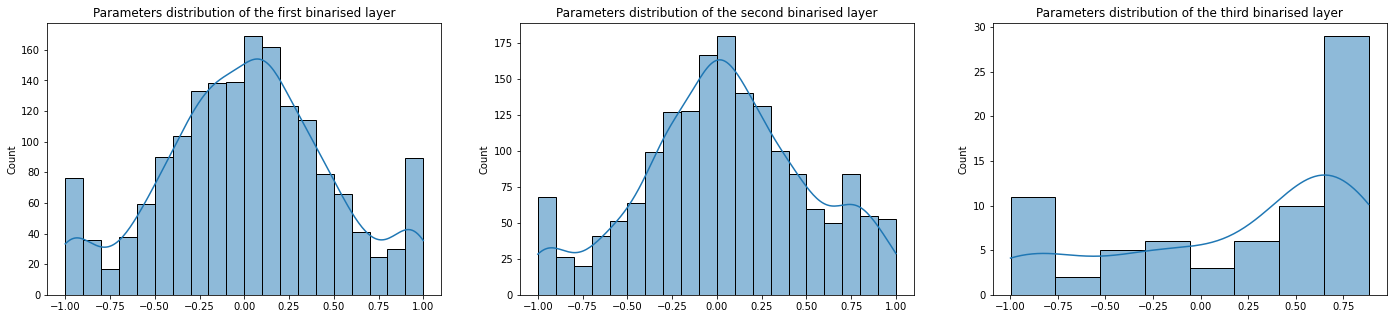

In [15]:
W=[np.array([estimator.kernel for estimator in models["ABCNet"].layers[2*i+2].estimators]) for i in range(3)]
fig,axs=plt.subplots(1,3,figsize=(24,5))
for i,(w,ax) in enumerate(zip(W,axs)):
    sns.histplot(w.flatten(),ax=ax,kde=True)
    ax.set_title(f"Parameters distribution of the {count_name(i+1)} binarised layer")
fig.savefig("local/parameters-distribution-abc-net.svg")

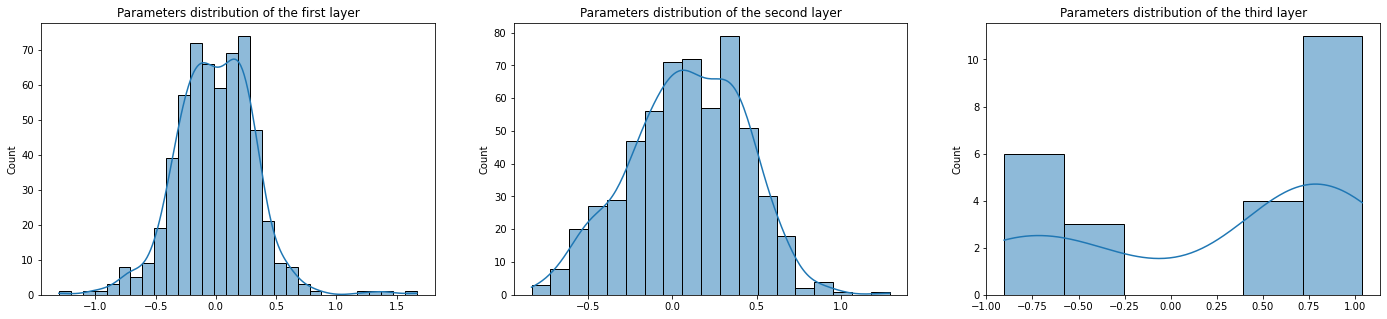

In [20]:
W=[models["MLP"].layers[2*i+2].kernel for i in range(3)]
fig,axs=plt.subplots(1,3,figsize=(24,5))
for i,(w,ax) in enumerate(zip(W,axs)):
    sns.histplot(w.numpy().flatten(),ax=ax,kde=True)
    ax.set_title(f"Parameters distribution of the {count_name(i+1)} layer")
fig.savefig("local/parameters-distribution-abc-net.svg")

## 7. Performance Test
We will mesure the model's performance using the squared $\mathcal{L}^2$ distance of the $\mathcal{C}([-4,4])$ space:
$$
  \mathcal{L}(F,\mathcal{M}_\theta)=\int_{-4}^4(M_\theta-F)^2d\mu = \int_{-4}^4 (M_\theta(x)-F(x))^2dx
$$

In [23]:
import scipy.integrate as integrate
n=2**20+1
samples=np.linspace(-4,4,n)
errors=[]
for name in models:
    row=[]
    model=models[name]
    row.append(name)
    err=np.abs(model(samples).numpy().flatten()-F(samples))
    row.append(np.max(err))
    for k in [1,2]:
        row.append(integrate.romb(err**k,dx=1/n))
    errors.append(row)
errors=pd.DataFrame(errors,columns=["Method","$\mathcal{L}^\infty$","$\mathcal{L}^1$","$\mathcal{L}^2$ Squared"])
errors["$\mathcal{L}^2$"]=np.sqrt(errors["$\mathcal{L}^2$ Squared"])
errors

,Method,$\mathcal{L}^\infty$,$\mathcal{L}^1$,$\mathcal{L}^2$ Squared,$\mathcal{L}^2$
0,BinaryNet,22.000000,3.655195,33.353148,5.775218
1,XNOR-NET,17.885567,3.807591,29.378610,5.420204
2,ABCNet,17.863966,2.941291,17.142549,4.140356
3,MLP,11.026714,2.846293,18.619267,4.315005


## 8. Saving Models

In [54]:
for name in models:
    models[name].save(f"trained/{name}Regression")

ValueError: Unable to create dataset (name already exists)

In [4]:
emissions

{'BinaryNet': 0.00016699914763920943,
 'XNOR-NET': 0.00019853084191643122,
 'ABCNet': 0.00029429914815744105,
 'MLP': 0.0001352601370710404}